In [10]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict
from sklearn.linear_model import LogisticRegression, Lasso
import seaborn as sns
import numpy as np
import utils
from Model import Model
import matplotlib.pyplot as plt
from tqdm import tqdm
from PrecisionMatrixBuilder import PrecisionMatrixBuilder
from Forecaster import Forecaster
from MyDataLoader import MyDataLoader
from PortfolioConstructor import PortfolioConstructor
from BackTester import BackTester
import torch

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

Stellantis and WLN have a lot of missing prices compared to the other stocks in the CAC40: we exclude them from this analysis.

In [11]:
dataloader = MyDataLoader()
full_dataset, stock_names, time_index = dataloader.load_full_dataset_array()

[*********************100%***********************]  40 of 40 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [12]:
column_names = dataloader.load_feature_names()

In [13]:
tscv = list(utils.time_series_cross_validation(full_dataset, time_index, n_splits=10, valid_size=66, test_size=66))

In [14]:
config = utils.load_config()
alphas = config["alphas"]
thetas = config["thetas"]
lambdas = config["lambdas"]
capital = config["capital"]

In [15]:
returns = dataloader.load_returns()

The following cells can be run once to download the precision matrix if it is not already saved. 

In [16]:
import pickle
precision_matrix_builder = PrecisionMatrixBuilder(returns = returns, window = 512, alphas = alphas, thetas = thetas)
prec_mat = precision_matrix_builder.get_precision_matrix()

100%|██████████| 3468/3468 [05:03<00:00, 11.41it/s]


In [17]:
with open('precision_mat.pkl', 'wb') as f:  # open a text file
    pickle.dump(prec_mat, f)

In [18]:
import pickle
with open("precision_mat.pkl", "rb") as f:
    prec_mat = pickle.load(f)

In [19]:
benchmark_returns = dataloader.load_benchmark(date_index=time_index)
risk_free = dataloader.load_risk_free_rate(time_index)

[*********************100%***********************]  1 of 1 completed


In [20]:
from Forecaster import Forecaster
forecaster = Forecaster(full_dataset, stock_names, time_index, valid_size=66, test_size=66, n_splits=10)

# Model Initialization

We now import and define the models of interest for each class: 

### MLP

In [10]:
from networks import MLP

hiddens1 = (torch.ones(10)*32).to(int)
hiddens2 = (torch.ones(10)*64).to(int)
hiddens3 = (torch.ones(50)*64).to(int)
model_1 = Model(name = "MultiLayerPerceptronRegression1", type = "regression", model_class= MLP(14, hiddens1, model_type="regression"))
model_2 = Model(name = "MultiLayerPerceptronRegression2", type = "regression", model_class= MLP(14, hiddens2, model_type="regression"))
model_3 = Model(name = "MultiLayerPerceptronRegression3", type = "regression", model_class= MLP(14, hiddens3, model_type="regression"))
model_4 = Model(name = "MultiLayerPerceptronClassification1", type = "classification", model_class= MLP(14, hiddens1, model_type="classification"))
model_5 = Model(name = "MultiLayerPerceptronClassification2", type = "classification", model_class= MLP(14, hiddens2, model_type="classification"))
model_6 = Model(name = "MultiLayerPerceptronClassification3", type = "classification", model_class= MLP(14, hiddens3, model_type="classification"))

MLP_models = [model_1, model_2, model_3, model_4, model_5, model_6]

tensor(32)
tensor(64)
tensor(64)
tensor(32)
tensor(64)
tensor(64)


We then perform training and forecasting on the defined models.

In [ ]:
forecasts_val, forecasts_test, weights_valid, weights_test, opt_param_dict, valid_index_full, test_index_full = forecaster.evaluate_test_models(models = MLP_models, prec_mat = prec_mat, lambdas = lambdas, alphas = alphas, thetas = thetas, capital = capital, stock_returns=returns, risk_free=risk_free, benchmark_returns=benchmark_returns)

In [101]:
weights_test_full_MLP_regressions = []
weights_test_full_MLP_classifications = []
for model in MLP_models: 
    if model.type == "regression": 
        weights_test_full_MLP_regressions.append(weights_test[model.name])
    else: 
        weights_test_full_MLP_classifications.append(weights_test[model.name])

Now, we perform backtesting and plot the results of the optimized portfolios.

Yearly excess returns        0.516115
Yearly standard deviation    1.619382
Max DD                       2.524873
Yearly Sharpe                0.318711
Yearly Calmar                0.204412
Yearly Sortino               0.521281
Daily Turnover               2.521689
dtype: float64
Yearly excess returns        -0.602915
Yearly standard deviation     1.733038
Max DD                       10.088440
Yearly Sharpe                -0.347895
Yearly Calmar                -0.059763
Yearly Sortino               -0.438230
Daily Turnover                1.989806
dtype: float64
Yearly excess returns        -0.017942
Yearly standard deviation     0.030659
Max DD                       13.464791
Yearly Sharpe                -0.585217
Yearly Calmar                -0.001333
Yearly Sortino               -0.825356
Daily Turnover                0.003378
dtype: float64


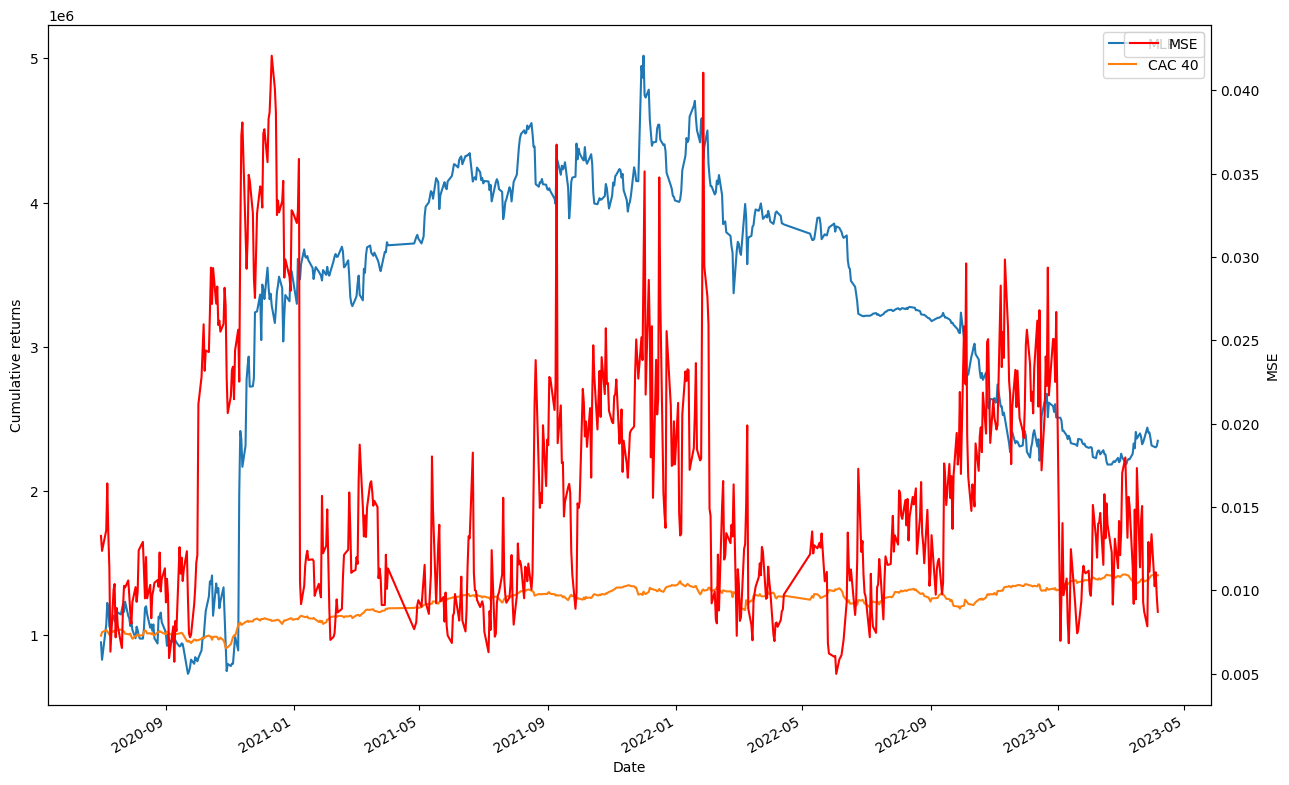

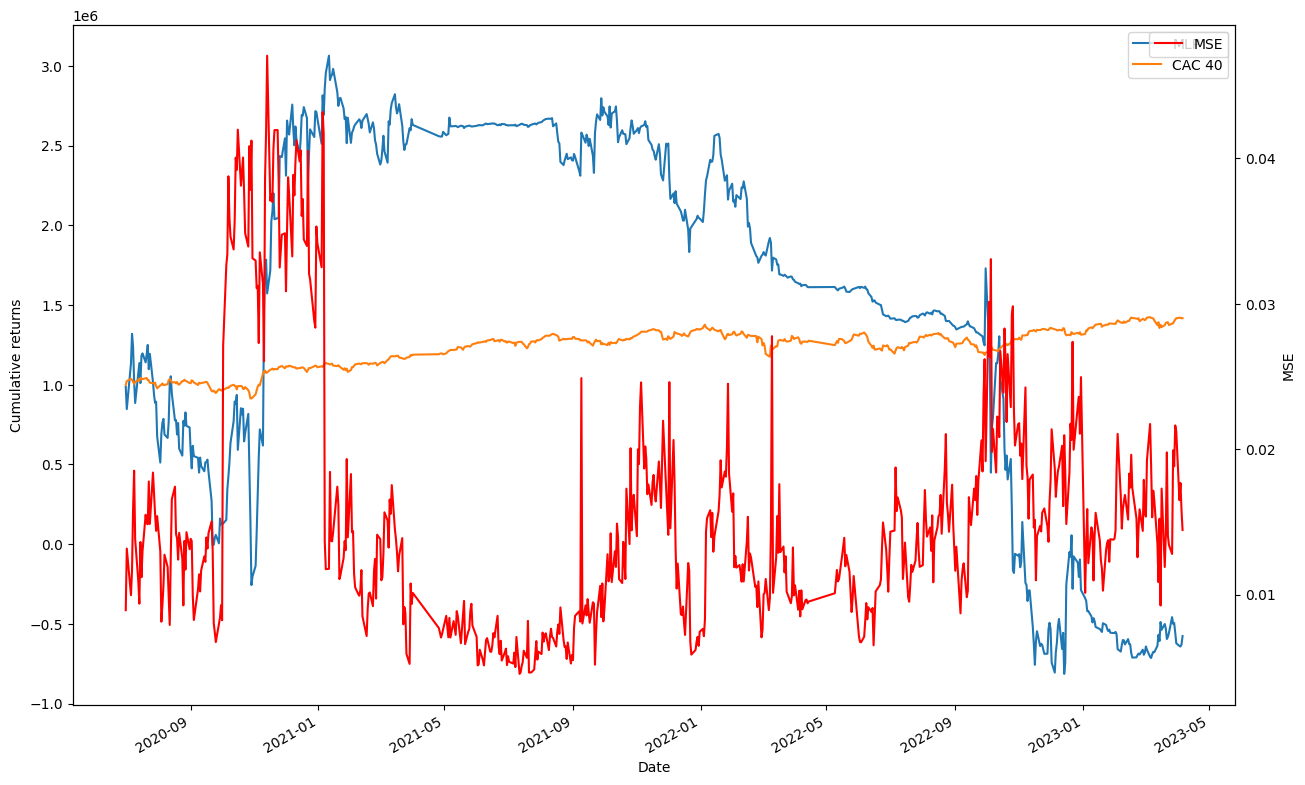

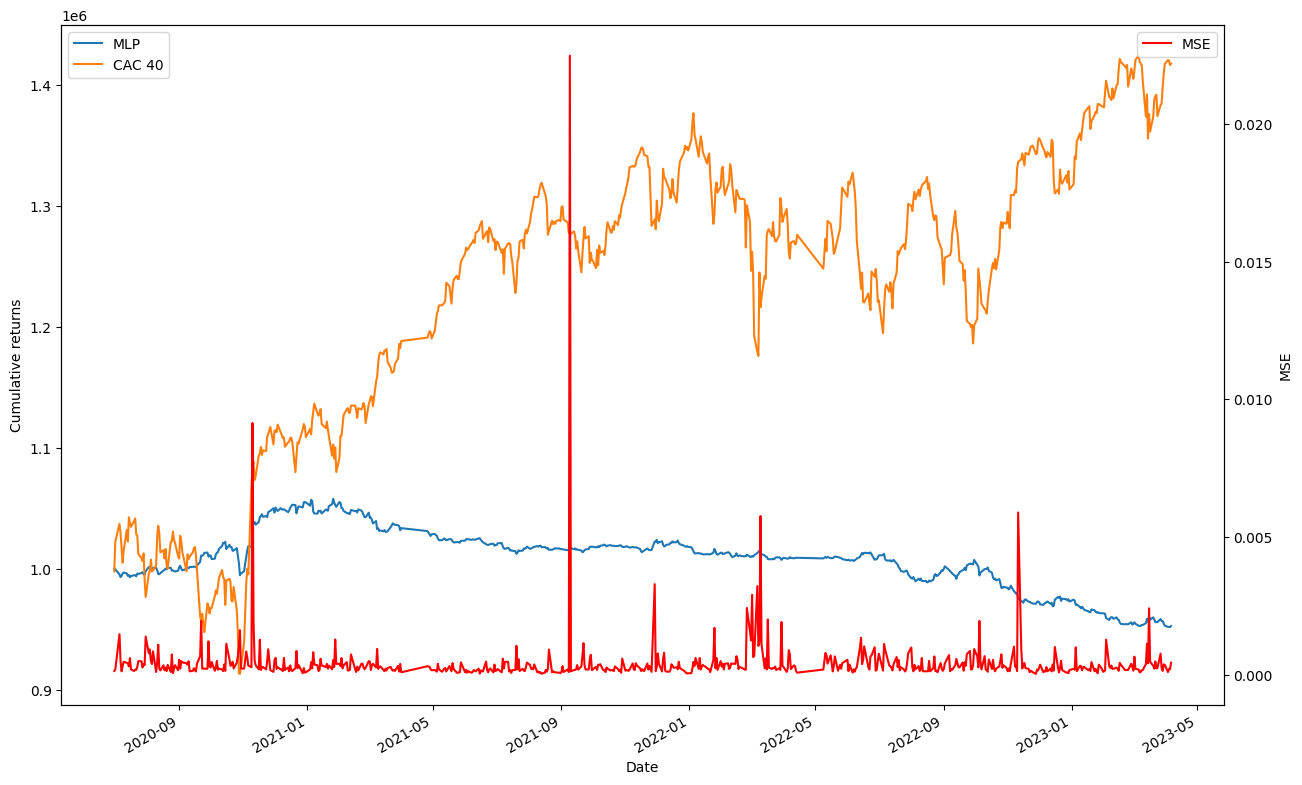

In [286]:
for model in MLP_models: 
    if model.type =="regression":
        w = weights_test[model.name]
        backtest = BackTester(w, returns, capital, risk_free, benchmark=benchmark_returns, name = "MLP")
        backtest_statistics = backtest.get_backtest_statistics()
        print(backtest_statistics)
        cum_returns = backtest.get_strategy_cumulative_returns()
        cum_returns["MSE"] = (forecasts_test[model.name] - returns.loc[test_index_full, :]).apply(lambda x: x**2).mean(axis = 1)

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        cum_returns.plot(y = ["MLP", "CAC 40"], ax = ax1, figsize = (15, 10))
        cum_returns.plot(y = "MSE", ax = ax2, color = "red")
        ax1.set_ylabel("Cumulative returns")
        ax2.set_ylabel("MSE")
        # ax1.set_title("MLP Regression with ")

We repeat this process to generate the classification graphs and statistics: 

Yearly excess returns          -1.501292
Yearly standard deviation       0.150705
Max DD                       2027.353891
Yearly Sharpe                  -9.961816
Yearly Calmar                  -0.000741
Yearly Sortino                -14.889081
Daily Turnover                  0.923108
dtype: float64
Yearly excess returns         -0.753224
Yearly standard deviation      0.185644
Max DD                       225.595591
Yearly Sharpe                 -4.057358
Yearly Calmar                 -0.003339
Yearly Sortino                -6.452146
Daily Turnover                 0.444582
dtype: float64
Yearly excess returns        0.000569
Yearly standard deviation    0.122865
Max DD                       5.015354
Yearly Sharpe                0.004633
Yearly Calmar                0.000113
Yearly Sortino               0.006622
Daily Turnover               0.004019
dtype: float64


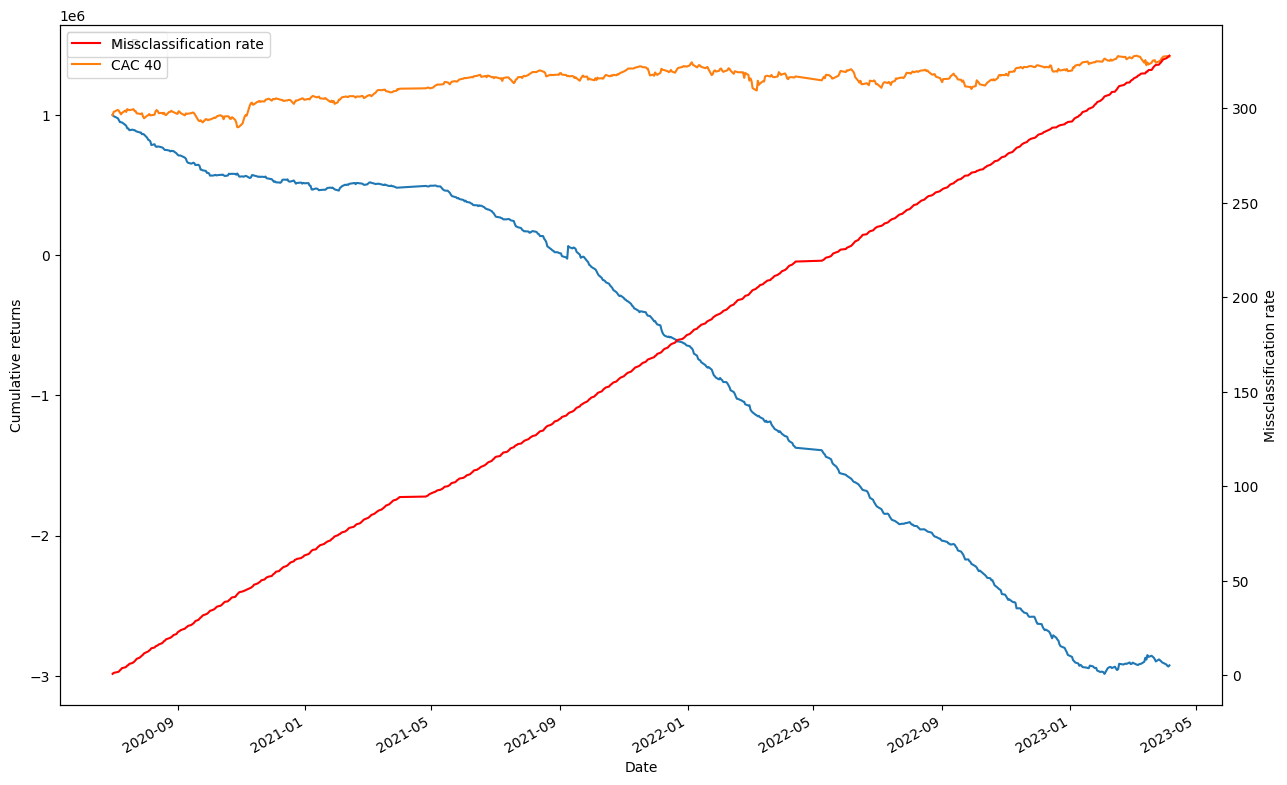

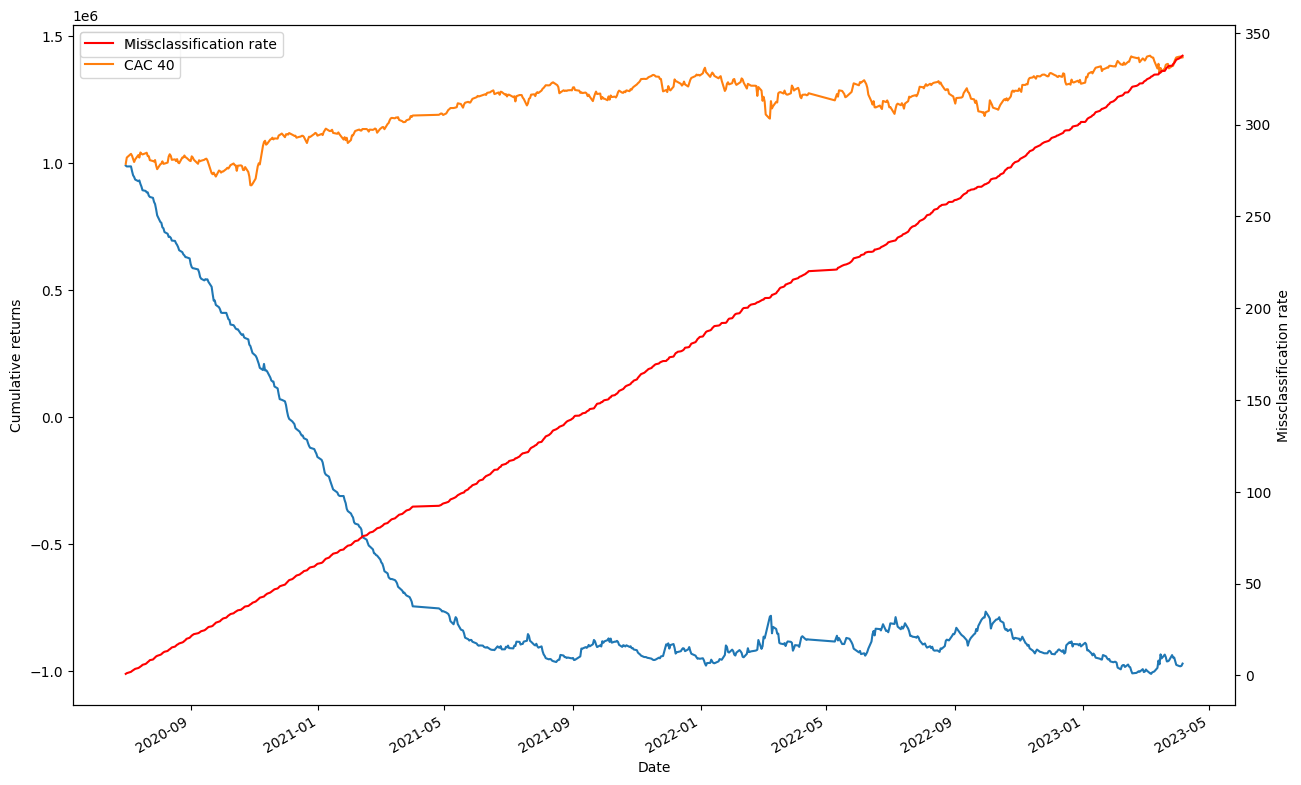

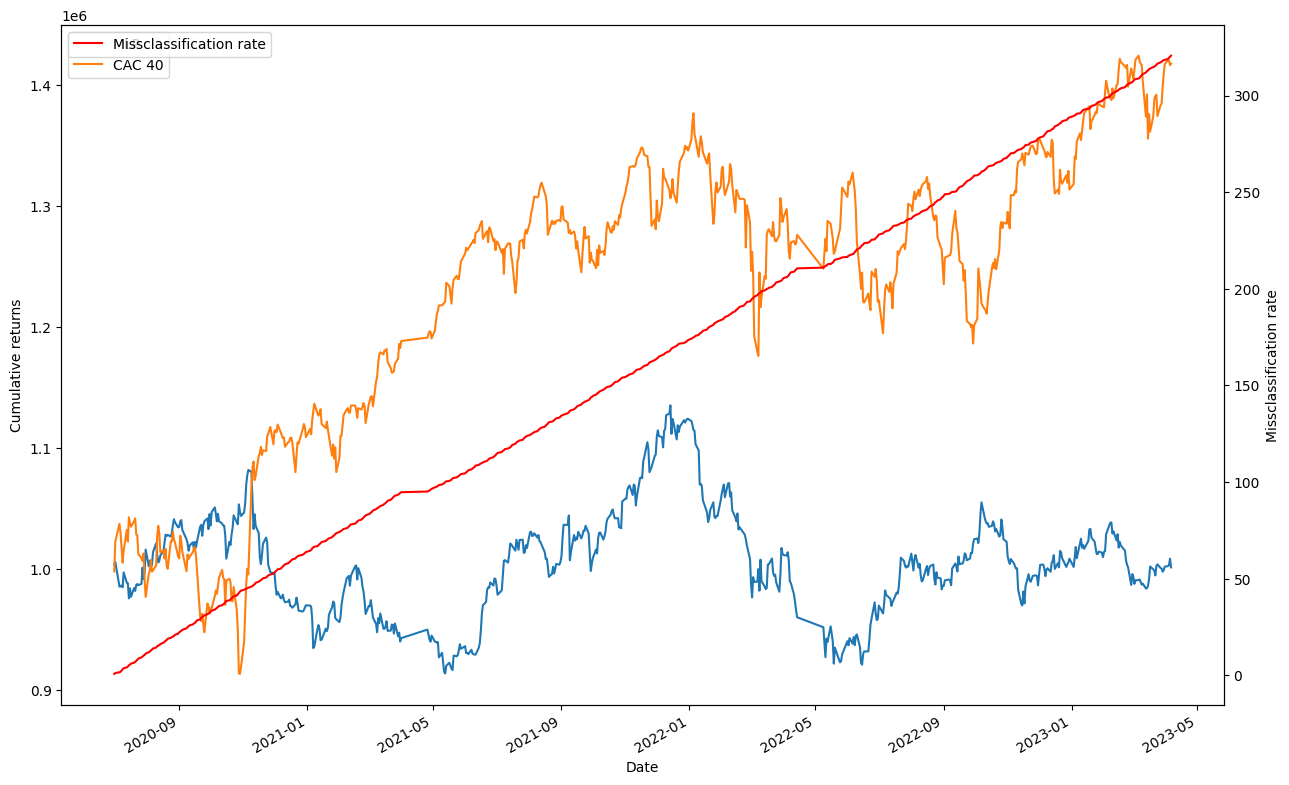

In [287]:
for model in MLP_models: 
    if model.type == "classification":
        w = weights_test[model.name]
        backtest = BackTester(w, returns, capital, risk_free, benchmark=benchmark_returns, name = "MLP")
        backtest_statistics = backtest.get_backtest_statistics()
        print(backtest_statistics)
        cum_returns = backtest.get_strategy_cumulative_returns()
        cum_returns["Missclassification rate"] = ((2*forecasts_test[model.name]-1) != np.sign(returns.loc[test_index_full, :])).abs().mean(axis = 1).cumsum()

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        cum_returns.plot(y = ["MLP", "CAC 40"], ax = ax1, figsize = (15, 10))
        cum_returns.plot(y = "Missclassification rate", ax = ax2, color = "red")
        ax1.set_ylabel("Cumulative returns")
        ax2.set_ylabel("Missclassification rate")

### CNN

In [21]:
from networks import CNN

In [23]:
model_6 = Model(name = "CNN1", type = "regression", model_class= CNN(14, [64], model_type="regression"))
model_7 = Model(name = "CNN2", type = "classification", model_class= CNN(14, [64], model_type= "classification"))
model_8 = Model(name = "CNN3", type = "regression", model_class= CNN(14, [128], model_type= "regression"))
model_9 = Model(name = "CNN4", type = "classification", model_class= CNN(14, [128], model_type= "classification"))
model_10 = Model(name = "CNN5", type = "regression", model_class= CNN(14, [32, 64], model_type= "regression"))
model_11 = Model(name = "CNN6", type = "classification", model_class= CNN(14, [32, 64], model_type= "classification"))
model_12 = Model(name = "CNN7", type = "regression", model_class= CNN(14, [32, 64, 128], model_type= "regression"))
model_13 = Model(name = "CNN8", type = "classification", model_class= CNN(14, [32, 64, 128], model_type= "classification"))

CNN_models = [model_6, model_8, model_10, model_12]

In [24]:
forecasts_val_cnn, forecasts_test_cnn, weights_valid_cnn, weights_test_cnn, opt_param_dict_cnn, valid_index_full_cnn, test_index_full_cnn = forecaster.evaluate_test_models(models = CNN_models, prec_mat = prec_mat, lambdas = lambdas, alphas = alphas, thetas = thetas, capital = capital, stock_returns=returns, risk_free=risk_free, benchmark_returns=benchmark_returns)

100%|██████████| 4/4 [06:21<00:00, 95.30s/it] 
10it [1:12:04, 432.43s/it]


Yearly excess returns        1.230593
Yearly standard deviation    2.653901
Max DD                       1.351555
Yearly Sharpe                0.463692
Yearly Calmar                0.910501
Yearly Sortino               0.735187
Daily Turnover               3.336302
dtype: float64
27.24491687220615
Yearly excess returns        2.473737
Yearly standard deviation    5.643457
Max DD                       9.294486
Yearly Sharpe                0.438337
Yearly Calmar                0.266151
Yearly Sortino               1.252561
Daily Turnover               3.709664
dtype: float64
33.43660364902806
Yearly excess returns         4.040595
Yearly standard deviation     4.144753
Max DD                       13.674451
Yearly Sharpe                 0.974870
Yearly Calmar                 0.295485
Yearly Sortino                3.411810
Daily Turnover                2.782066
dtype: float64
25.94072991238875
Yearly excess returns        2.430642
Yearly standard deviation    3.021030
Max DD              

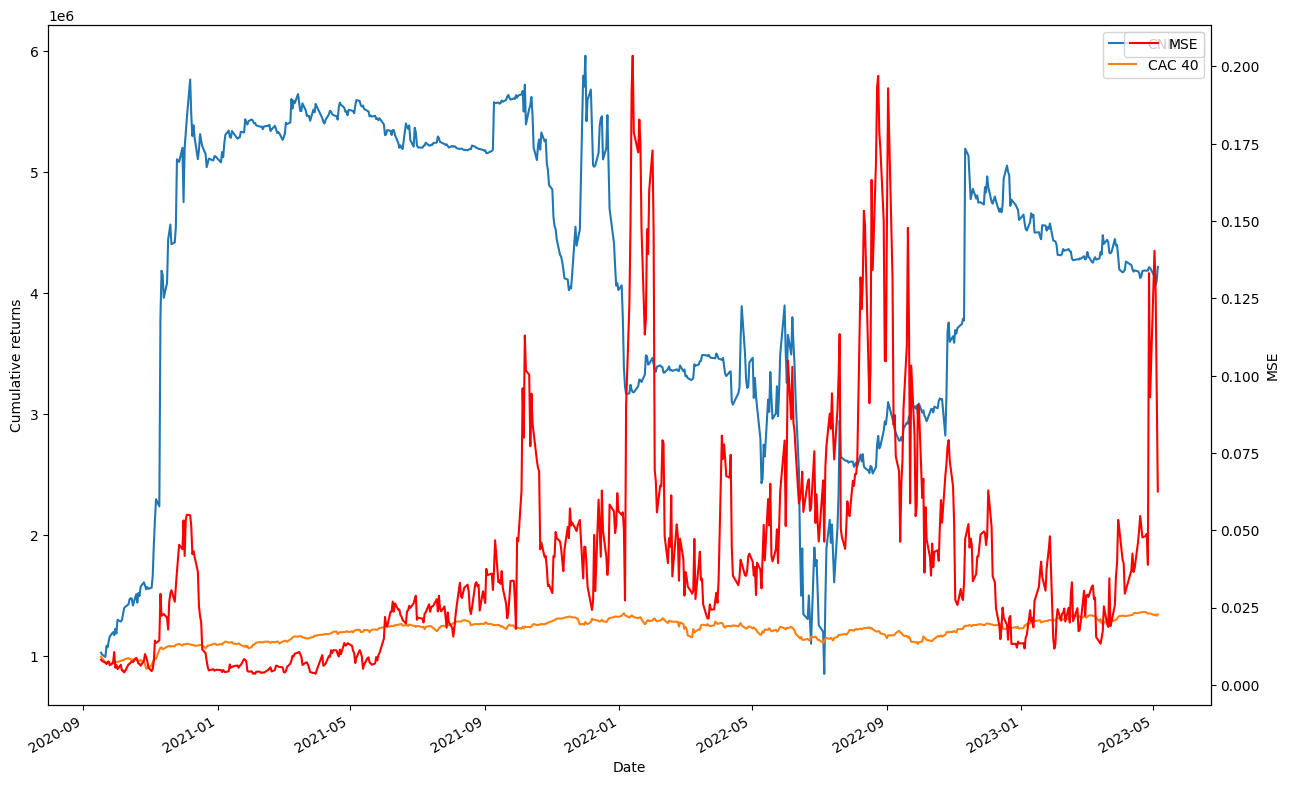

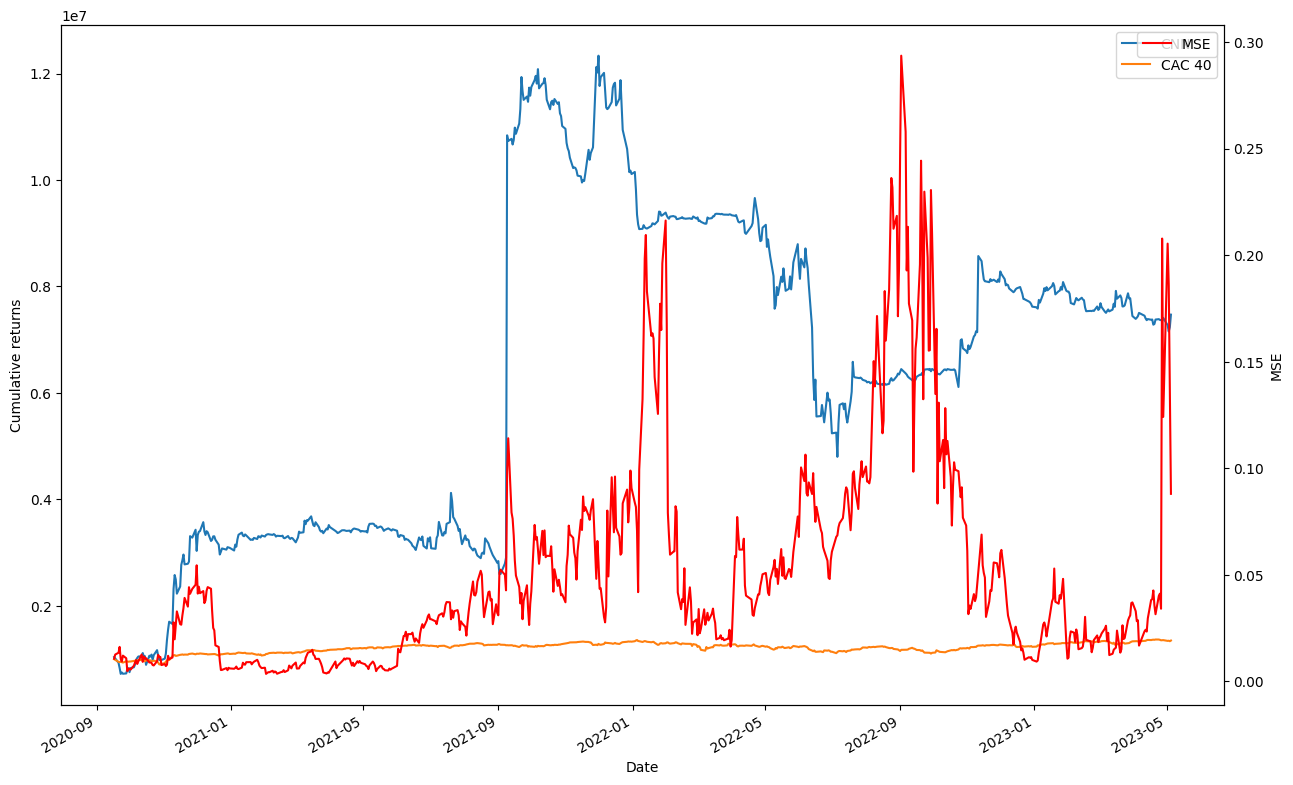

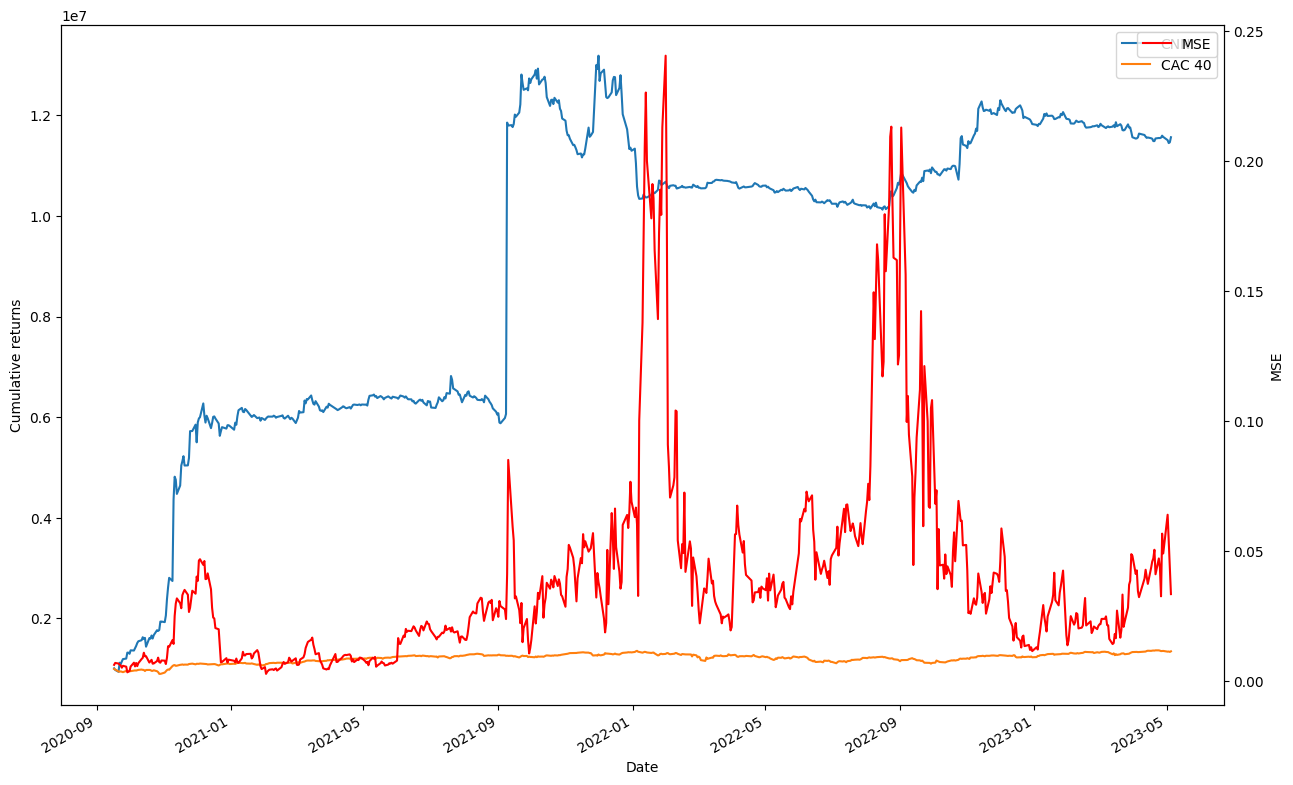

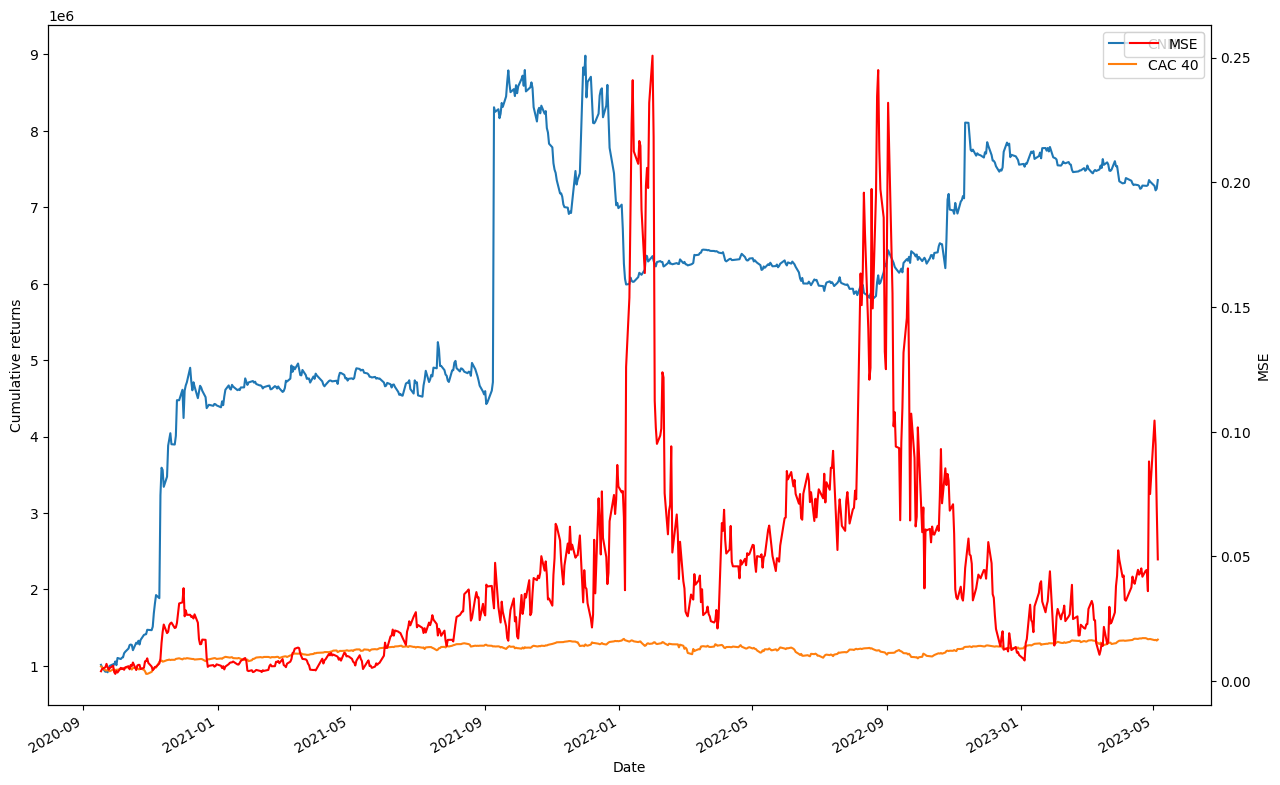

In [26]:
for model in CNN_models: 
    if model.type =="regression":
        w = weights_test_cnn[model.name]
        backtest = BackTester(w, returns, capital, risk_free, benchmark=benchmark_returns, name = "CNN")
        backtest_statistics = backtest.get_backtest_statistics()
        print(backtest_statistics)
        cum_returns = backtest.get_strategy_cumulative_returns()
        cum_returns["MSE"] = (forecasts_test_cnn[model.name] - returns.loc[test_index_full_cnn, :]).apply(lambda x: x**2).mean(axis = 1)

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        cum_returns.plot(y = ["CNN", "CAC 40"], ax = ax1, figsize = (15, 10))
        cum_returns.plot(y = "MSE", ax = ax2, color = "red")
        ax1.set_ylabel("Cumulative returns")
        ax2.set_ylabel("MSE")
        print(cum_returns["MSE"].sum())

Yearly excess returns        -0.070919
Yearly standard deviation     0.172304
Max DD                       54.900897
Yearly Sharpe                -0.411593
Yearly Calmar                -0.001292
Yearly Sortino               -0.559345
Daily Turnover                0.063137
dtype: float64
Average daily missclassification rate = 0.47696368581027093
Yearly excess returns         0.644069
Yearly standard deviation     0.660811
Max DD                       10.383371
Yearly Sharpe                 0.974664
Yearly Calmar                 0.062029
Yearly Sortino                4.046441
Daily Turnover                0.223948
dtype: float64
Average daily missclassification rate = 0.4718045112781953
Yearly excess returns          -3.977071
Yearly standard deviation       0.333501
Max DD                       1007.347678
Yearly Sharpe                 -11.925199
Yearly Calmar                  -0.003948
Yearly Sortino                -12.008297
Daily Turnover                  1.393620
dtype: float64
Ave

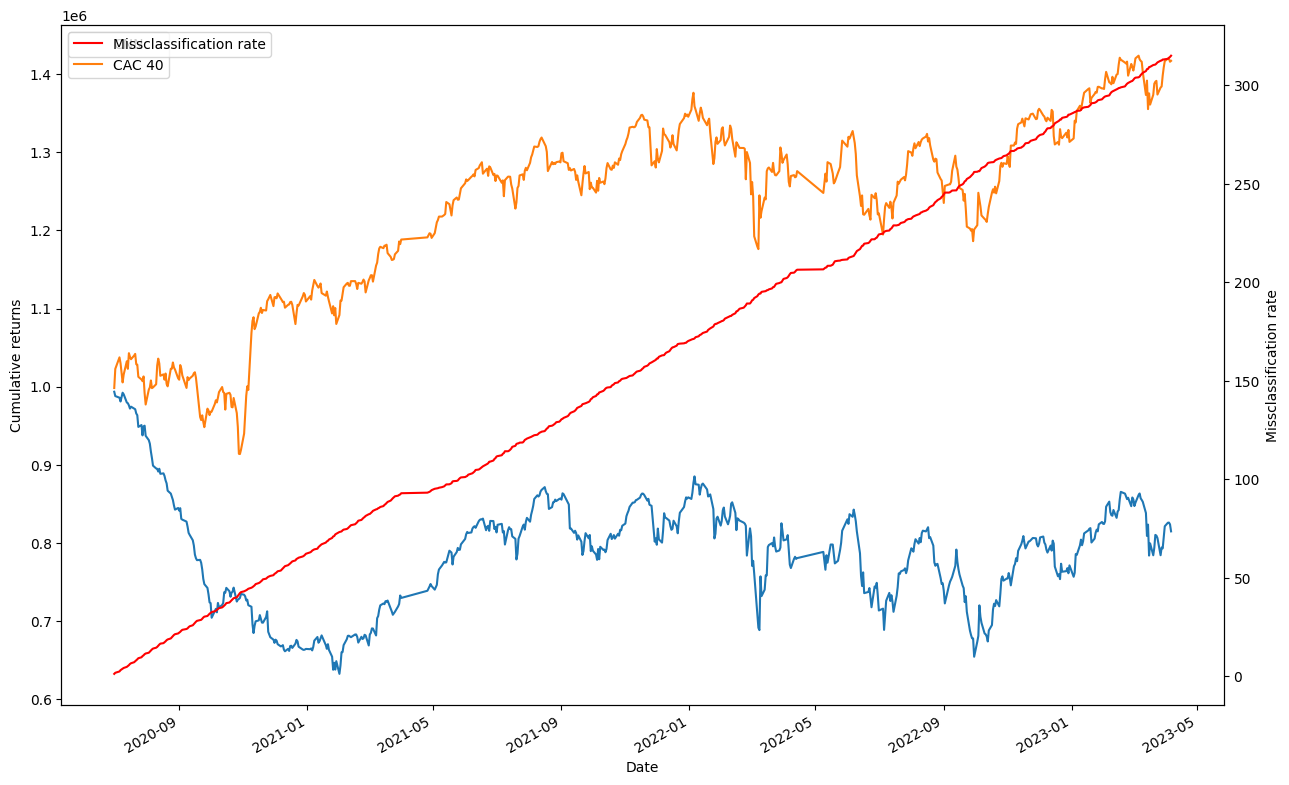

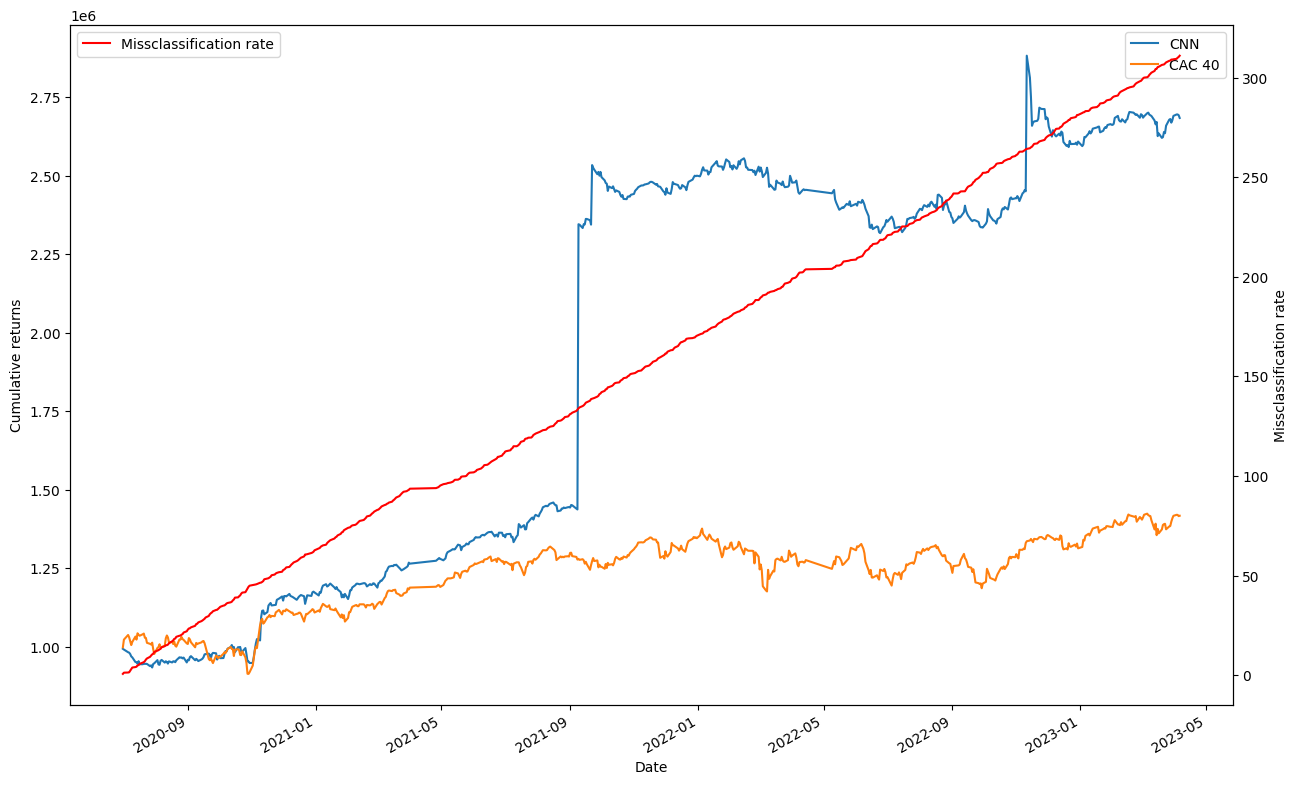

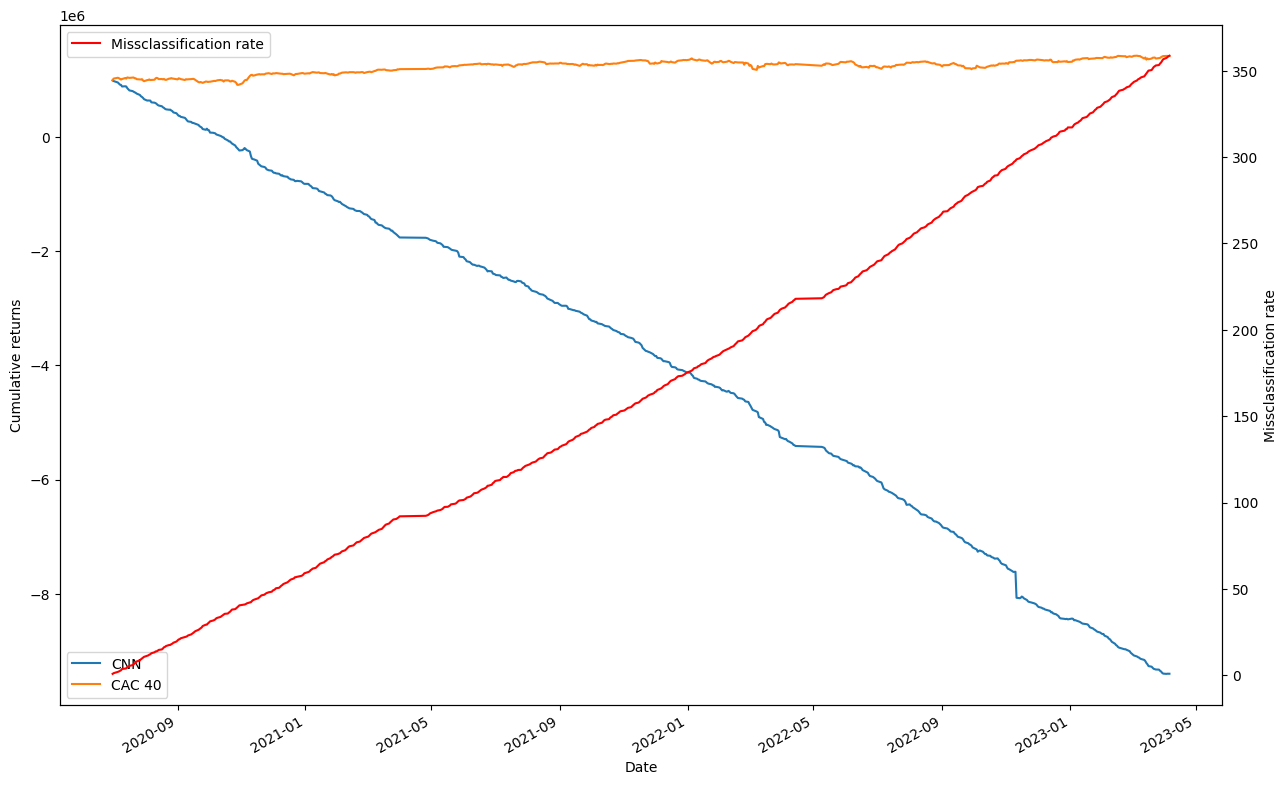

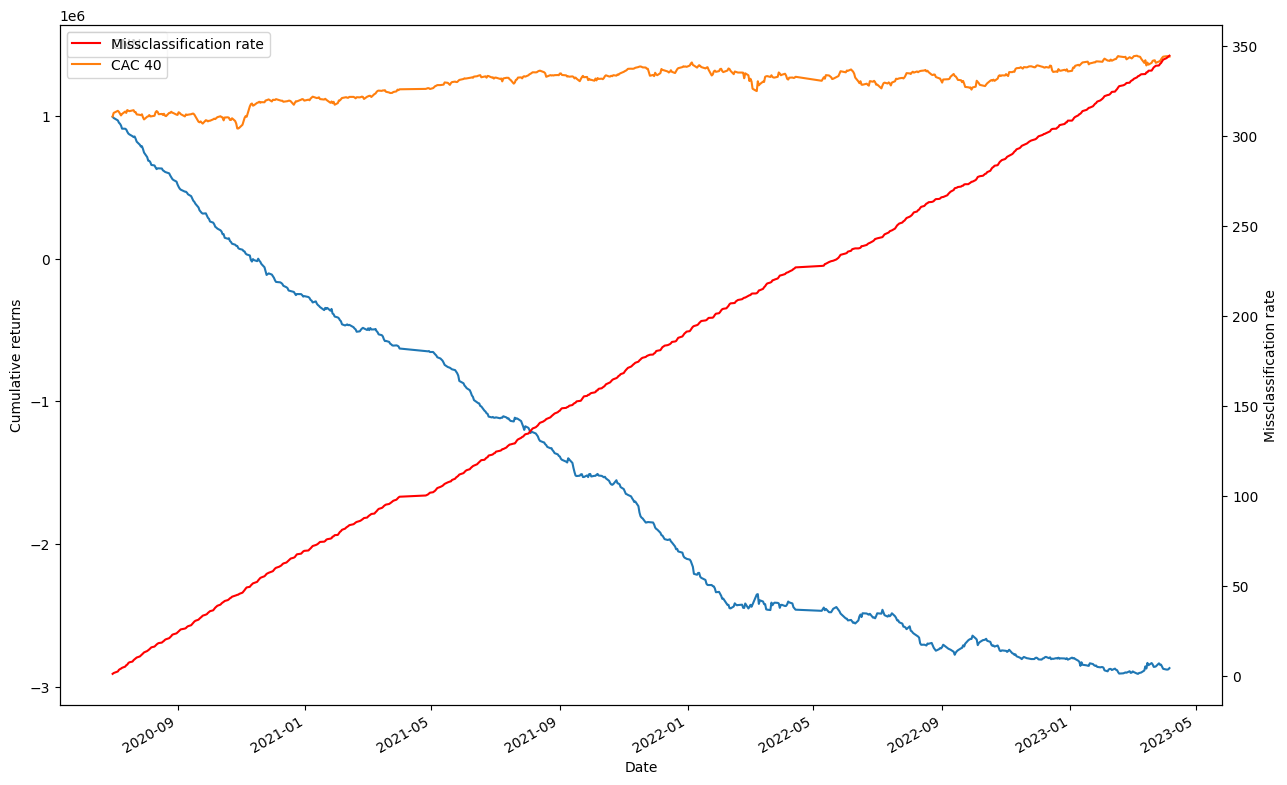

In [20]:
for model in CNN_models: 
    if model.type == "classification":
        w = weights_test_cnn[model.name]
        backtest = BackTester(w, returns, capital, risk_free, benchmark=benchmark_returns, name = "CNN")
        backtest_statistics = backtest.get_backtest_statistics()
        print(backtest_statistics)
        cum_returns = backtest.get_strategy_cumulative_returns()
        cum_returns["Missclassification rate"] = ((2*forecasts_test_cnn[model.name]-1) != np.sign(returns.loc[test_index_full_cnn, :])).abs().mean(axis = 1).cumsum()
        print(f"Average daily missclassification rate = {cum_returns['Missclassification rate'].diff().mean()}")
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        cum_returns.plot(y = ["CNN", "CAC 40"], ax = ax1, figsize = (15, 10))
        cum_returns.plot(y = "Missclassification rate", ax = ax2, color = "red")
        ax1.set_ylabel("Cumulative returns")
        ax2.set_ylabel("Missclassification rate")

We can see that, on average, the best performing classification models are the ones with the lowest misclassification rate.

### LSTM

In [525]:
from networks import LSTM
lstm_models = []
lstm_models.append(Model(name= "LSTMRegression", type = "regression", model_class= LSTM(14, 60, 1, "regression"), is_rnn=True))
lstm_models.append(Model(name= "LSTMClassification", type = "classification", model_class= LSTM(14, 60, 1, "classification"), is_rnn=True))
lstm_models_2 = []
lstm_models_2.append(Model(name= "LSTMRegression", type = "regression", model_class= LSTM(14, 60, 3, "regression"), is_rnn=True))
lstm_models_2.append(Model(name= "LSTMClassification", type = "classification", model_class= LSTM(14, 60, 3, "classification"), is_rnn=True))

In [ ]:
forecasts_val_lstm_2, forecasts_test_lstm_2, weights_valid_lstm_2, weights_test_lstm_2, opt_param_dict_lstm_2, valid_index_full_lstm_2, test_index_full_lstm_2 = forecaster.evaluate_test_models(models = lstm_models_2, prec_mat = prec_mat, lambdas = lambdas, alphas = alphas, thetas = thetas, capital = capital, stock_returns=returns, risk_free=risk_free, benchmark_returns=benchmark_returns)

In [526]:
forecasts_val_lstm, forecasts_test_lstm, weights_valid_lstm, weights_test_lstm, opt_param_dict_lstm, valid_index_full_lstm, test_index_full_lstm = forecaster.evaluate_test_models(models = lstm_models, prec_mat = prec_mat, lambdas = lambdas, alphas = alphas, thetas = thetas, capital = capital, stock_returns=returns, risk_free=risk_free, benchmark_returns=benchmark_returns)

100%|██████████| 2/2 [23:14<00:00, 697.26s/it]
10it [5:55:30, 2133.05s/it]


LSTMRegression
(10, 66, 38)
LSTMClassification
(10, 66, 38)


Yearly excess returns        0.169559
Yearly standard deviation    1.403011
Max DD                       2.505925
Yearly Sharpe                0.120854
Yearly Calmar                0.067663
Yearly Sortino               0.188113
Daily Turnover               1.415939
dtype: float64


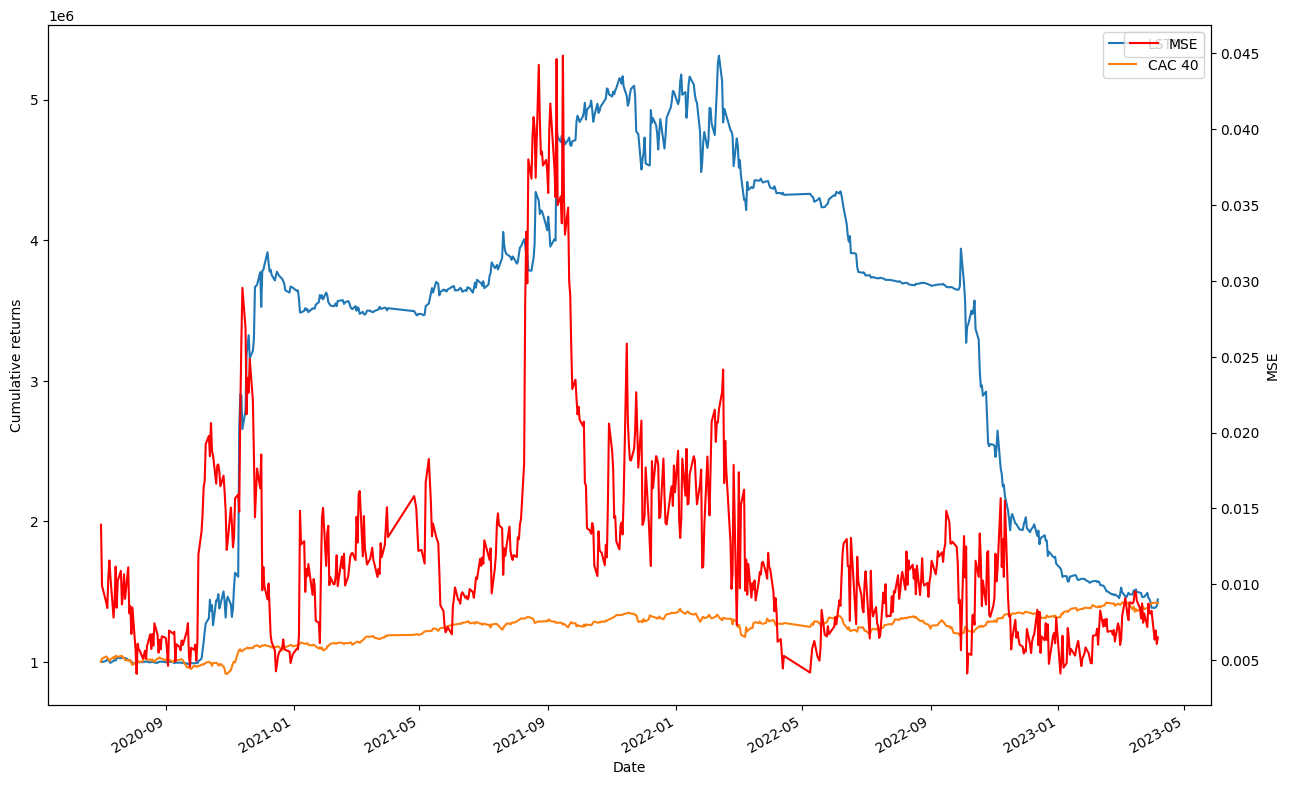

In [527]:
for model in lstm_models: 
    if model.type =="regression":
        w = weights_test_lstm[model.name]
        backtest = BackTester(w, returns, capital, risk_free, benchmark=benchmark_returns, name = "LSTM")
        backtest_statistics = backtest.get_backtest_statistics()
        print(backtest_statistics)
        cum_returns = backtest.get_strategy_cumulative_returns()
        cum_returns["MSE"] = (forecasts_test_lstm[model.name] - returns.loc[test_index_full, :]).apply(lambda x: x**2).mean(axis = 1)

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        cum_returns.plot(y = ["LSTM", "CAC 40"], ax = ax1, figsize = (15, 10))
        cum_returns.plot(y = "MSE", ax = ax2, color = "red")
        ax1.set_ylabel("Cumulative returns")
        ax2.set_ylabel("MSE")
        # ax1.set_title("MLP Regression with ")

Yearly excess returns          -3.937328
Yearly standard deviation       0.149574
Max DD                       5362.695651
Yearly Sharpe                 -26.323645
Yearly Calmar                  -0.000734
Yearly Sortino                -29.202283
Daily Turnover                  2.090823
dtype: float64


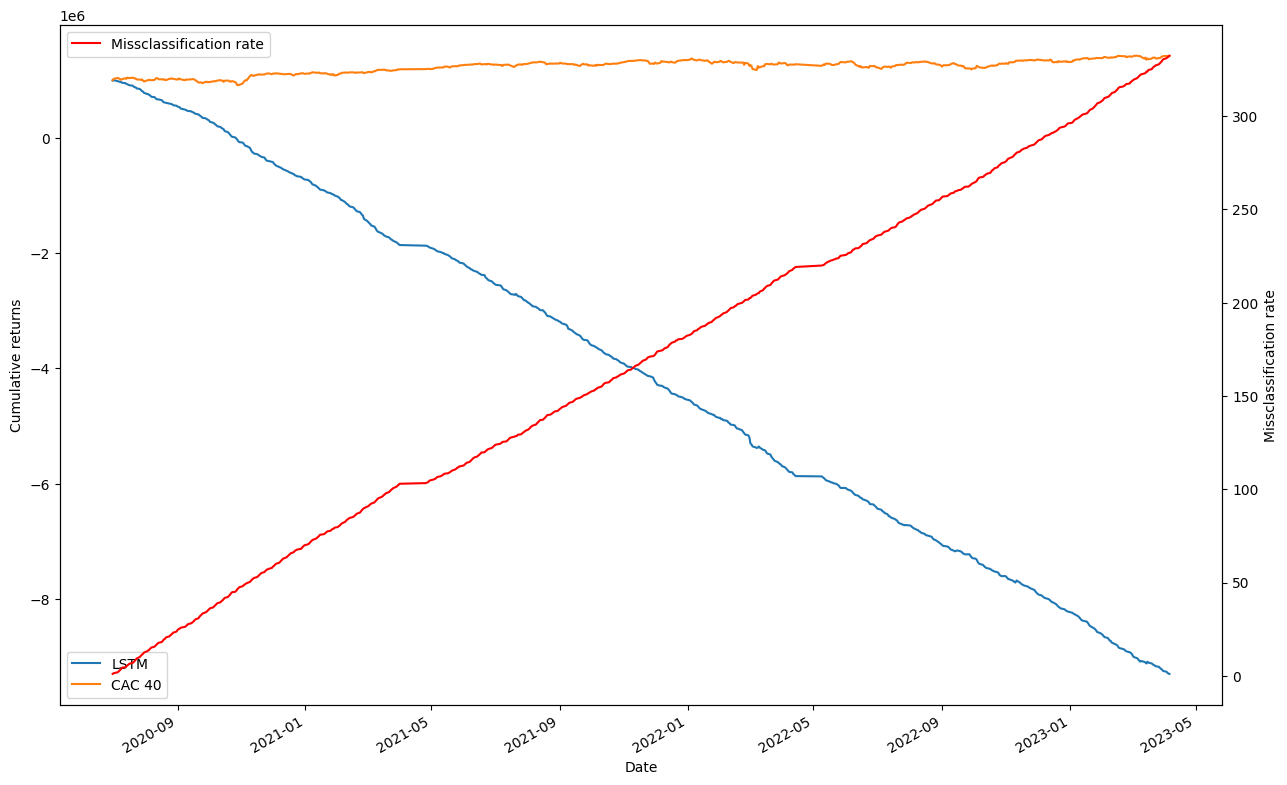

In [528]:
for model in lstm_models: 
    if model.type == "classification":
        w = weights_test_lstm[model.name]
        backtest = BackTester(w, returns, capital, risk_free, benchmark=benchmark_returns, name = "LSTM")
        backtest_statistics = backtest.get_backtest_statistics()
        print(backtest_statistics)
        cum_returns = backtest.get_strategy_cumulative_returns()
        cum_returns["Missclassification rate"] = ((2*forecasts_test_lstm[model.name]-1) != np.sign(returns.loc[test_index_full, :])).abs().mean(axis = 1).cumsum()

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        cum_returns.plot(y = ["LSTM", "CAC 40"], ax = ax1, figsize = (15, 10))
        cum_returns.plot(y = "Missclassification rate", ax = ax2, color = "red")
        ax1.set_ylabel("Cumulative returns")
        ax2.set_ylabel("Missclassification rate")

### GRU

In [514]:
from networks import GRU
import Forecaster
gru_models = []
gru_models.append(Model(name= "GRURegression", type = "regression", model_class= GRU(14, 64, 1, "regression"), is_rnn=True))
gru_models.append(Model(name= "GRUClassification", type = "classification", model_class= GRU(14, 64, 1, "classification"), is_rnn=True))

In [516]:
forecasts_val_gru, forecasts_test_gru, weights_valid_gru, weights_test_gru, opt_param_dict_gru, valid_index_full_gru, test_index_full_gru = forecaster.evaluate_test_models(models = gru_models, prec_mat = prec_mat, lambdas = lambdas, alphas = alphas, thetas = thetas, capital = capital, stock_returns=returns, risk_free=risk_free, benchmark_returns=benchmark_returns)

100%|██████████| 2/2 [20:33<00:00, 616.85s/it]
10it [3:10:57, 1145.76s/it]

GRURegression
(10, 66, 38)
GRUClassification
(10, 66, 38)


Yearly excess returns       -0.487695
Yearly standard deviation    1.649790
Max DD                       2.219283
Yearly Sharpe               -0.295610
Yearly Calmar               -0.219753
Yearly Sortino              -0.424335
Daily Turnover               0.903226
dtype: float64


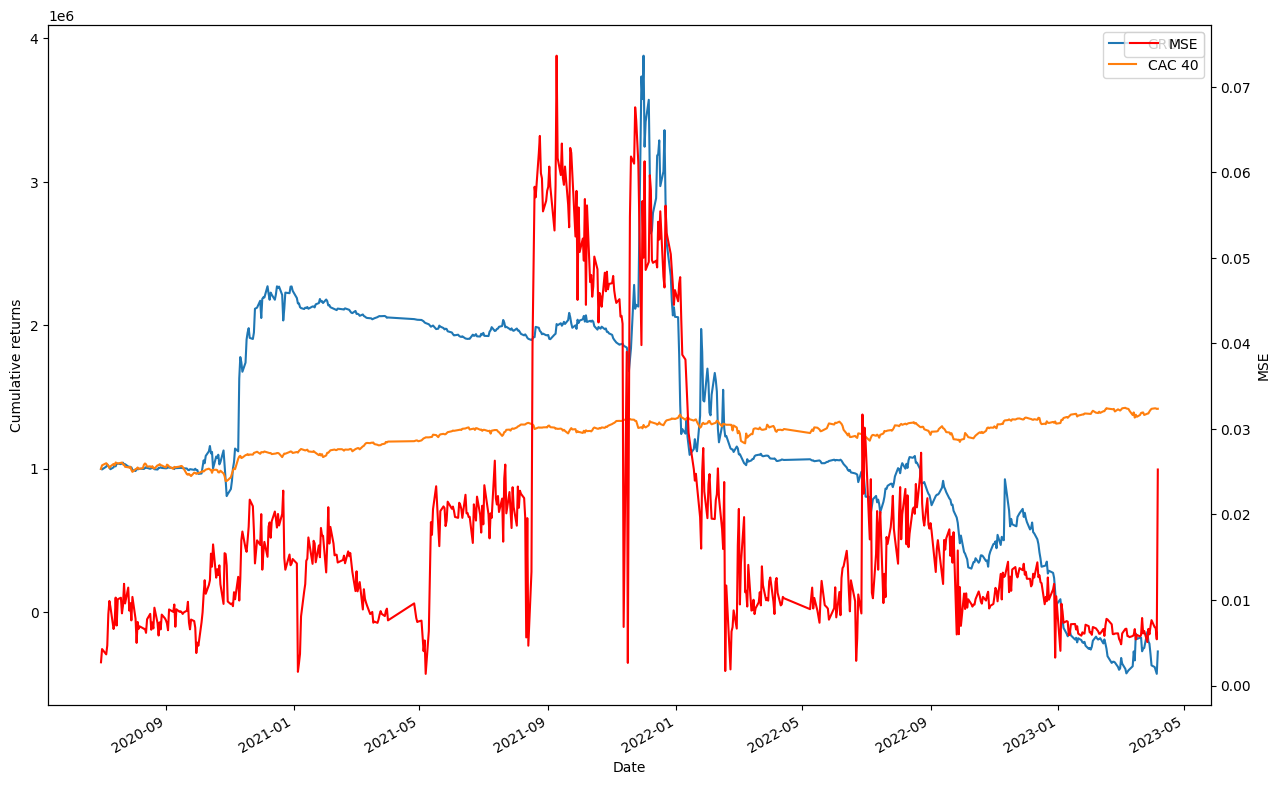

In [521]:
for model in gru_models: 
    if model.type =="regression":
        w = weights_test_gru[model.name]
        backtest = BackTester(w, returns, capital, risk_free, benchmark=benchmark_returns, name = "GRU")
        backtest_statistics = backtest.get_backtest_statistics()
        print(backtest_statistics)
        cum_returns = backtest.get_strategy_cumulative_returns()
        cum_returns["MSE"] = (forecasts_test_gru[model.name] - returns.loc[test_index_full, :]).apply(lambda x: x**2).mean(axis = 1)

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        cum_returns.plot(y = ["GRU", "CAC 40"], ax = ax1, figsize = (15, 10))
        cum_returns.plot(y = "MSE", ax = ax2, color = "red")
        ax1.set_ylabel("Cumulative returns")
        ax2.set_ylabel("MSE")
        # ax1.set_title("MLP Regression with ")

Yearly excess returns         -4.361938
Yearly standard deviation      0.164819
Max DD                       723.223341
Yearly Sharpe                -26.465064
Yearly Calmar                 -0.006031
Yearly Sortino               -30.658844
Daily Turnover                 2.262994
dtype: float64


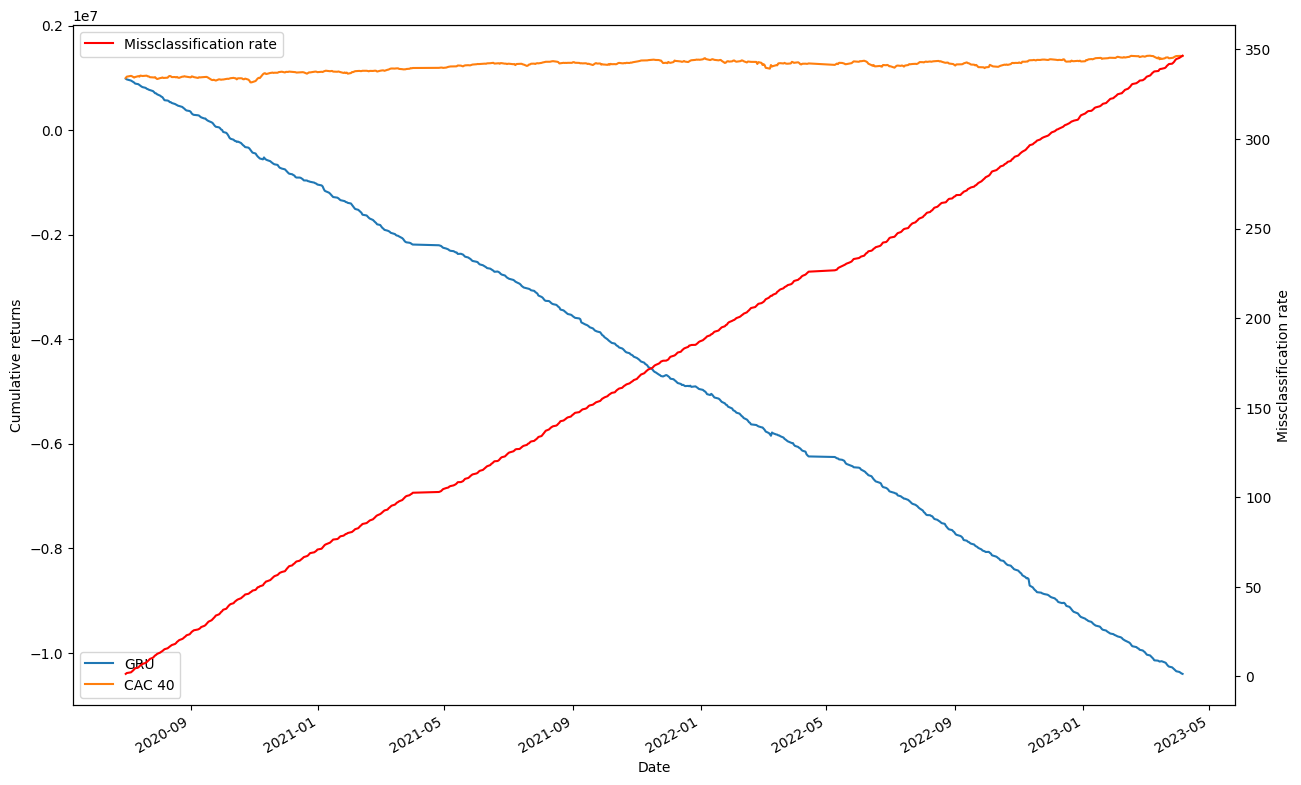

In [522]:
for model in gru_models: 
    if model.type == "classification":
        w = weights_test_gru[model.name]
        backtest = BackTester(w, returns, capital, risk_free, benchmark=benchmark_returns, name = "GRU")
        backtest_statistics = backtest.get_backtest_statistics()
        print(backtest_statistics)
        cum_returns = backtest.get_strategy_cumulative_returns()
        cum_returns["Missclassification rate"] = ((2*forecasts_test_gru[model.name]-1) != np.sign(returns.loc[test_index_full, :])).abs().mean(axis = 1).cumsum()

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        cum_returns.plot(y = ["GRU", "CAC 40"], ax = ax1, figsize = (15, 10))
        cum_returns.plot(y = "Missclassification rate", ax = ax2, color = "red")
        ax1.set_ylabel("Cumulative returns")
        ax2.set_ylabel("Missclassification rate")